# Lab 5: Sampling for evaluation

#### We will start by importing numpy, pandas, and matplotlib. (We will import other libraries/packages as we need them.) We will also read our spambase csv file into a pandas dataframe.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

spambase = pd.read_csv('spambase.csv')

print("Spambase loaded.")

Spambase loaded.


#### Let's build our logistic regression model.

In [2]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split

# first we need to prepare the data

# add an intercept column
spambase['_intercept'] = 1

# Copy spambase across and drop spam_class (we don't include the class feature in the training data)
X = spambase
X = X.drop('spam_class', axis=1)

# Set y as the spam column, we need to wrap it in the dataframe to stop it being series 
y_df = pd.DataFrame(spambase.spam_class)

# flatten y into a 1-D array
y = np.ravel(y_df)

# now split the data into training data and test data (80/20 split)
# random_state = k sets a specific random seed
# since random_state is fixed, this call will always produce the same split
# if you leave out the random_state value, you will get a different random split when you run it agaimn
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

# create our model and fit it to our training data
# the large C value essentail turns off regularization (which we will cover later)
# ignore it for now
logres = LogisticRegression(C = 1e9)
logres.fit(X_train,y_train)

# let's check our training and test accuracy
train_score = logres.score(X_train, y_train)
test_score = logres.score(X_test, y_test)

print ("Score on training data:", train_score)
print ("Score on test data:", test_score)

Score on training data: 0.932880434783
Score on test data: 0.909880564604


#### In the cell below, I have provided code that computes and prints the mean of the training and test errors for ten RANDOM train/test splits. Add code to compute and print the corresponding standard deviations.

In [3]:
# compute and print the mean of the training and test errors for ten RANDOM train/test splits

# insert code here
i = 0
total_holdouts = 10
acc = np.zeros((total_holdouts))
tpr = np.zeros((total_holdouts))
fpr = np.zeros((total_holdouts))
while (i < total_holdouts):
    X_tr, X_te, y_tr, y_te = train_test_split(X, y, test_size=0.2)

    lr = logres.fit(X_tr, y_tr)
    
    #y_pred = logres.fit(X_tr, y_tr).predict(X_te)
    y_pred = lr.predict(X_te)
    
    # compute confusion matrix
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    j = 0
    while (j < len(y_te)):
        if (y_pred[j]==y_te[j]):
            if (y_te[j]==0): # tn
                tn = tn + 1
            else: # tp
                tp = tp + 1
        else:
            if (y_te[j]==0): # fp
                fp = fp + 1
            else: # fn
                fn = fn + 1        
        j = j + 1
    acc[i] = (tp+tn)/j
    tpr[i] = tp/(tp+fn)
    fpr[i] = fp/(fp+tn)
    i = i + 1
        
# include mean and std dev
mean_acc = 0
mean_tpr = 0
mean_fpr = 0
i = 0
while (i < total_holdouts):
    mean_acc = mean_acc + acc[i]
    mean_tpr = mean_tpr + tpr[i]
    mean_fpr = mean_fpr + fpr[i]
    i = i + 1
    
mean_acc = mean_acc/total_holdouts
mean_tpr = mean_tpr/total_holdouts
mean_fpr = mean_fpr/total_holdouts

# ADD CODE TO COMPUTE AND PRINT THE STANDARD DEVIATIONS OF THE THREE STATISTICS

std_acc = np.std(acc)
std_tpr = np.std(tpr)
std_fpr = np.std(fpr)


print("HOLDOUT STATS")
print("Accuracy: mean = ",mean_acc)
print("TPR: mean = ",mean_tpr)
print("FPR: mean = ",mean_fpr)


print ("Accuracy: Standard Deviation = ", std_acc)
print ("TPR: Standard Deviation = ", std_tpr)
print ("FPR: Standard Deviation = ", std_fpr)


HOLDOUT STATS
Accuracy: mean =  0.925732899023
TPR: mean =  0.891513860428
FPR: mean =  0.0522061899326
Accuracy: Standard Deviation =  0.0106627437109
TPR: Standard Deviation =  0.0176991756029
FPR: Standard Deviation =  0.0113587620705


#### Bootstrap: In cell below, I have provided code that computes the average performance across b bootstrap samples.

In [4]:
import random

# average performance across b=5 bootstrap samples
total_bootstraps = 5

bootstrap_size = len(y)

i = 0
bootstrap_idx = np.zeros((bootstrap_size+1))
acc = 0
while (i < total_bootstraps):
    # create bootstrap training and set
    j = 0
    while (j < bootstrap_size): 
        bootstrap_idx[j] = random.randint(0,bootstrap_size-1)
        j = j + 1
    bootstrap_idx[j] = j # add value to enable stopping duribng bootstrap creation
    
    bootstrap_idx.sort()
    
    j = 0
    boots_idx = 0
    X_te = pd.DataFrame(columns=X.columns)
    y_te = pd.DataFrame(columns=y_df.columns)
    X_tr = pd.DataFrame(columns=X.columns)
    y_tr = pd.DataFrame(columns=y_df.columns)
    done = False
    while (done==False):
        if (bootstrap_idx[boots_idx] != j):
            df = X[j:j+1]
            X_te = X_te.append(df, ignore_index=True)
            df = y_df[j:j+1]
            y_te = y_te.append(df, ignore_index=True)
        else:
            while (bootstrap_idx[boots_idx] == j):
                df = X[j:j+1]
                X_tr = X_tr.append(df, ignore_index=True)
                df = y_df[j:j+1]
                y_tr = y_tr.append(df, ignore_index=True)
                boots_idx = boots_idx + 1   
        j = j + 1
        if (j==bootstrap_size):
            done = True
        if (boots_idx==bootstrap_size):
            done = True

    print("Fraction of instances in test data = ", len(y_te)/len(y))  
                
    # fit model and make predictions
    y_tr = np.ravel(y_tr)
    y_tr = y_tr.astype('int')
    y_te = np.ravel(y_te)
    y_te = y_te.astype('int')
    lr = logres.fit(X_tr, y_tr)
    
    y_tr_pred = lr.predict(X_tr)
    y_te_pred = lr.predict(X_te)
    
    # compute bootstrap accuracy
    te_acc = 0
    j = 0
    while (j < len(y_te)):
        if (y_te[j] == y_te_pred[j]):
            te_acc = te_acc + 1
        j = j + 1
    
    tr_acc = 0
    j = 0
    while (j < len(y_tr)):
        if (y_tr[j] == y_tr_pred[j]):
            tr_acc = tr_acc + 1
        j = j + 1
    
    te_acc = te_acc/len(y_te)
    tr_acc = tr_acc/len(y_tr)
    acc = acc + (.632*te_acc) + (.368*tr_acc)
    
    i = i + 1  
  
acc = acc/total_bootstraps
print("BOOTSTRAP STATS")
print("Accuracy = ", acc)


Fraction of instances in test data =  0.36209519669637036
Fraction of instances in test data =  0.3668767659204521
Fraction of instances in test data =  0.36405129319713103
Fraction of instances in test data =  0.3644859813084112
Fraction of instances in test data =  0.36405129319713103
BOOTSTRAP STATS
Accuracy =  0.9276823331147984


#### 10-fold cv: In the box below, I have include code to perform and report statistics for 10-fold cv. Review the code and add code to plot a stacked bargraph showing the distribution of class for each fold.

In [1]:
from sklearn.model_selection import KFold

k = 10

X_df = spambase
X_df = X_df.drop('spam_class', axis=1)

X = np.ravel(X_df).reshape(4601, 58)

# Set y as the spam column, we need to wrap it in the dataframe to stop it being series 
y_df = pd.DataFrame(spambase.spam_class)

# flatten y into a 1-D array
y = np.ravel(y_df)

kf = KFold(n_splits=10, shuffle=True, random_state=None)

tp = 0
fp = 0
tn = 0
fn = 0

spam_bar = []
non_spam_bar = []

for train_index, test_index in kf.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_tr, X_te = X[train_index], X[test_index]
    y_tr, y_te = y[train_index], y[test_index]
    lr = logres.fit(X_tr, y_tr)
    y_te_pred = lr.predict(X_te)
 
    # compute confusion matrix statistics
    j = 0
    while (j < len(y_te)):
        if (y_te_pred[j]==y_te[j]):
            if (y_te[j]==0): # tn
                tn = tn + 1
            else: # tp
                tp = tp + 1
        else:
            if (y_te[j]==0): # fp
                fp = fp + 1
            else: # fn
                fn = fn + 1        
        j = j + 1
     
    total = y_te.size    
    non_zero=np.count_nonzero(y_te)    
    zero = total - non_zero

    spam_num = non_zero/total
    not_spam = zero/total
    spam_bar.append(spam_num)
    non_spam_bar.append(not_spam)
   
    
    
acc = (tp+tn)/len(y)
tpr = tp/(tp+fn)
fpr = fp/(fp+tn)

print("Acc, TPR, FPR = ", acc, tpr, fpr)
print (spam_bar,'\n', non_spam_bar)

# Add code for the plotting of stacked bar graph show distribution of classes for each fold


# non_zero=np.count_nonzero(y_te)

# total = y_te.size
# zero = total - non_zero

# spam_num = non_zero/total
# not_spam = zero/total

# spam_num = np.array(spam_num)
# not_spam = np.array(not_spam)
# print (non_zero, zero, spam_num, not_spam)

N = 10
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, spam_bar, width)
p2 = plt.bar(ind, non_spam_bar, width, bottom=spam_bar)

plt.legend((p1[0],p2[1]),('Spam','Not Spam'),loc='lower right')
plt.xlabel('Folds')
plt.title('Class Distribution by Fold')

plt.show()

NameError: name 'spambase' is not defined

#### Stratified 10-fold cv:  In the box below, write code that performs stratified 10-fold cv and print the final performance statistics (acc, tpr, fpr). Include the code for the stacked bar chart.

Acc, TPR, FPR =  0.9265377091936535 0.8885824600110315 0.04878048780487805
[0.3947939262472885, 0.3947939262472885, 0.3947939262472885, 0.3934782608695652, 0.3934782608695652, 0.3934782608695652, 0.3934782608695652, 0.3934782608695652, 0.39433551198257083, 0.39433551198257083] 
 [0.6052060737527115, 0.6052060737527115, 0.6052060737527115, 0.6065217391304348, 0.6065217391304348, 0.6065217391304348, 0.6065217391304348, 0.6065217391304348, 0.6056644880174292, 0.6056644880174292]


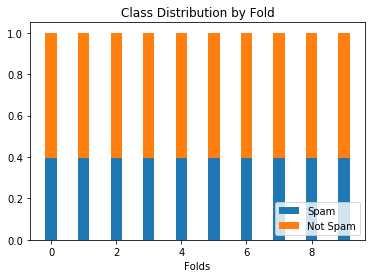

In [6]:

from sklearn.model_selection import KFold,StratifiedKFold

k = 10

X_df = spambase
X_df = X_df.drop('spam_class', axis=1)

X = np.ravel(X_df).reshape(4601, 58)

# Set y as the spam column, we need to wrap it in the dataframe to stop it being series 
y_df = pd.DataFrame(spambase.spam_class)

# flatten y into a 1-D array
y = np.ravel(y_df)

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=None)

tp = 0
fp = 0
tn = 0
fn = 0

spam_bar = []
non_spam_bar = []

# insert code here
for train_index, test_index in skf.split(X,y):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_tr, X_te = X[train_index], X[test_index]
    y_tr, y_te = y[train_index], y[test_index]
    lr = logres.fit(X_tr, y_tr)
    y_te_pred = lr.predict(X_te)
 
    # compute confusion matrix statistics
    j = 0
    while (j < len(y_te)):
        if (y_te_pred[j]==y_te[j]):
            if (y_te[j]==0): # tn
                tn = tn + 1
            else: # tp
                tp = tp + 1
        else:
            if (y_te[j]==0): # fp
                fp = fp + 1
            else: # fn
                fn = fn + 1        
        j = j + 1
     
    total = y_te.size    
    non_zero=np.count_nonzero(y_te)    
    zero = total - non_zero

    spam_num = non_zero/total
    not_spam = zero/total
    spam_bar.append(spam_num)
    non_spam_bar.append(not_spam)
   
    
    
acc = (tp+tn)/len(y)
tpr = tp/(tp+fn)
fpr = fp/(fp+tn)

print("Acc, TPR, FPR = ", acc, tpr, fpr)
print (spam_bar,'\n', non_spam_bar)

# Add code for the plotting of stacked bar graph show distribution of classes for each fold


# non_zero=np.count_nonzero(y_te)

# total = y_te.size
# zero = total - non_zero

# spam_num = non_zero/total
# not_spam = zero/total

# spam_num = np.array(spam_num)
# not_spam = np.array(not_spam)
# print (non_zero, zero, spam_num, not_spam)

N = 10
ind = np.arange(N)    # the x locations for the groups
width = 0.35       # the width of the bars: can also be len(x) sequence

p1 = plt.bar(ind, spam_bar, width)
p2 = plt.bar(ind, non_spam_bar, width, bottom=spam_bar)

plt.legend((p1[0],p2[1]),('Spam','Not Spam'),loc='lower right')
plt.xlabel('Folds')
plt.title('Class Distribution by Fold')

plt.show()

# include stacked bar graph

#### loo cv: In the bow below, write code that performs leave-one-out cv and print the final performance statistics (acc, tpr, fpr).

In [7]:
# insert code here
from sklearn.model_selection import LeaveOneOut

k = 10

X_df = spambase
X_df = X_df.drop('spam_class', axis=1)

X = np.ravel(X_df).reshape(4601, 58)

# Set y as the spam column, we need to wrap it in the dataframe to stop it being series 
y_df = pd.DataFrame(spambase.spam_class)

# flatten y into a 1-D array
y = np.ravel(y_df)

loo_cv = LeaveOneOut()
# skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=None)

tp = 0
fp = 0
tn = 0
fn = 0

# spam_bar = []
# non_spam_bar = []

# insert code here
for train_index, test_index in loo_cv.split(X):
    #print("TRAIN:", train_index, "TEST:", test_index)
    X_tr, X_te = X[train_index], X[test_index]
    y_tr, y_te = y[train_index], y[test_index]
    lr = logres.fit(X_tr, y_tr)
    y_te_pred = lr.predict(X_te)
 
    # compute confusion matrix statistics
    j = 0
    while (j < len(y_te)):
        if (y_te_pred[j]==y_te[j]):
            if (y_te[j]==0): # tn
                tn = tn + 1
            else: # tp
                tp = tp + 1
        else:
            if (y_te[j]==0): # fp
                fp = fp + 1
            else: # fn
                fn = fn + 1        
        j = j + 1
  
    
acc = (tp+tn)/len(y)
tpr = tp/(tp+fn)
fpr = fp/(fp+tn)

print("Acc, TPR, FPR = ", acc, tpr, fpr)

Acc, TPR, FPR =  0.927841773527494 0.8885824600110315 0.046628407460545196
